In [33]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import optuna.visualization as vis
import os
from nolds import sampen

In [79]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 80.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')
fs = sampling_rate_equipo  # Sampling rate
sampling_rate = 3003 ### simulacion 


In [84]:
resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación del programa:")
    print(resultado_compilacion.stderr)


def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion_s= subprocess.run(f" OMP_NUM_THREADS=2 ./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion_s.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion_s.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion_s.stdout.strip().split('\n')

    data_list = [float(line) for line in lines]

    data = np.array(data_list)[120:]

    if(Normalizacion=="max_global"):    
        data=data/max(data)
    elif(Normalizacion=="zscore"):
        data=(data-np.mean(data))/np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=60, adaptive=True,verbose=False,n_jobs=1)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies > 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies > 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies > 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies > 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [85]:
def read_all_signals_from_folders(parent_folder):

    all_signals = []
    
    # Iterar sobre las subcarpetas en la carpeta principal
    for folder_name in sorted(os.listdir(parent_folder)):
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.isdir(folder_path):  # Asegurarse de que es una carpeta
            # Leer señales de la carpeta actual
            senal_uni, _ = read_signals(folder_path)
            all_signals.extend(senal_uni)  # Agregar todas las señales de esta carpeta
    
    # Concatenar todas las señales en un solo array
    all_signals_array = np.concatenate(all_signals)
    
    # Calcular valores globales
    global_min = np.min(all_signals_array)
    global_max = np.max(all_signals_array)
    global_mean = np.mean(all_signals_array)
    global_std = np.std(all_signals_array)
    
    return all_signals_array, global_min, global_max, global_mean, global_std

def read_signals(folder_path):
    signals = []
    file_names = []
    for file_name in sorted(os.listdir(folder_path)):  # Ordenar los archivos por nombre
        if file_name.endswith(".txt"):  # Filtrar solo archivos de texto
            file_path = os.path.join(folder_path, file_name)
            signal_i = np.loadtxt(file_path)  # Leer los datos del archivo
            signals.append(signal_i)
            file_names.append(file_name)  # Guardar el nombre del archivo
    return signals, file_names

def euclidean_distance(function1, function2):
    return np.sqrt(np.sum((np.array(function1) - np.array(function2))**2))

parent_folder = "Datos_reales"
all_signals_array, global_min, global_max, global_mean, global_std = read_all_signals_from_folders(parent_folder)

# Imprimir resultados
print("Número total de señales:", len(all_signals_array))
print("Mínimo global:", global_min)
print("Máximo global:", global_max)
print("Media global:", global_mean)
print("Desviación estándar global:", global_std)

Número total de señales: 32000
Mínimo global: -7.5019798015625e-05
Máximo global: 3.7541179509375e-05
Media global: -1.8103846518043457e-05
Desviación estándar global: 1.8481663638416723e-05


In [86]:
def Datos_reales(directorio,Normalizacion, global_min, global_max, global_mean, global_std):
    Datos,nombres= read_signals(directorio)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.zeros((len(nombres), 2)) 
    Theta = np.zeros((len(nombres), 2)) 
    Alpha = np.zeros((len(nombres), 2)) 
    Beta = np.zeros((len(nombres), 2)) 
    if(Normalizacion=="max_global"):    
            Datos=Datos/global_max
    elif(Normalizacion=="zscore"):
        Datos=(Datos-global_mean) / global_std
    for i in range(len(Datos)):
        Butter[i]=butter= signal.filtfilt(b, a,Datos[i])
        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=60, adaptive=True,verbose=False,n_jobs=1)
        Frequencies[i]=frequencies=np.array(frequencies)
        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        delta = welch_data[np.logical_and(frequencies > 0, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies > 3, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies > 7, frequencies <= 14)]
        beta = welch_data[np.logical_and(frequencies > 14, frequencies <= 30)]
        Delta[i]=np.array([delta.mean(),delta.std()])
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]
    mean_welch=np.mean(welch_datos)
    mean_Delta=[Delta[:,0].mean(),np.mean(Delta[:,1])]
    mean_Theta=[Theta[:,0].mean(),np.mean(Theta[:,1])]
    mean_Alpha=[Alpha[:,0].mean(),np.mean(Alpha[:,1])]
    mean_Beta=[Beta[:,0].mean(),np.mean(Beta[:,1])]
    return {
        "Nombres":nombres,"Zona":directorio,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [92]:
Params= {'L': 74, 'P': 0.21297691195330298, 'Inh': 0.7697472471751007, 'Trest': 0.713886070534507, 'Trelative': 3.606306293420138, 'C_h': 0.3207721141296828, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,12132, Params["Tipo_red"]]
Normalizacion="zscore"###"max_global""max_global_abs" zscore
generated_data= Simulado_EGG(initial_params,Normalizacion)
Zona="C"
reales_total = Datos_reales(f"Datos_reales/{Zona}",Normalizacion, global_min, global_max, global_mean, global_std)
print(reales_total["datos"])
print(len(reales_total["datos"][0]))
print(len(generated_data["data"]))
print(len(generated_data["data_resample"]))
print(len(generated_data["butter"]))

[[ 0.93283757  0.87687104  0.82904716 ...  0.41492784  0.43776648
   0.38462768]
 [-1.11805772 -1.03114086 -0.99631013 ... -1.65891962 -1.64719585
  -1.65110722]
 [ 0.38296613  0.34173687  0.33768102 ... -0.16936152 -0.14537734
  -0.17564654]]
2000
12012
2000
2000


['C3_MNE.txt', 'C4_MNE.txt', 'Cz_MNE.txt']


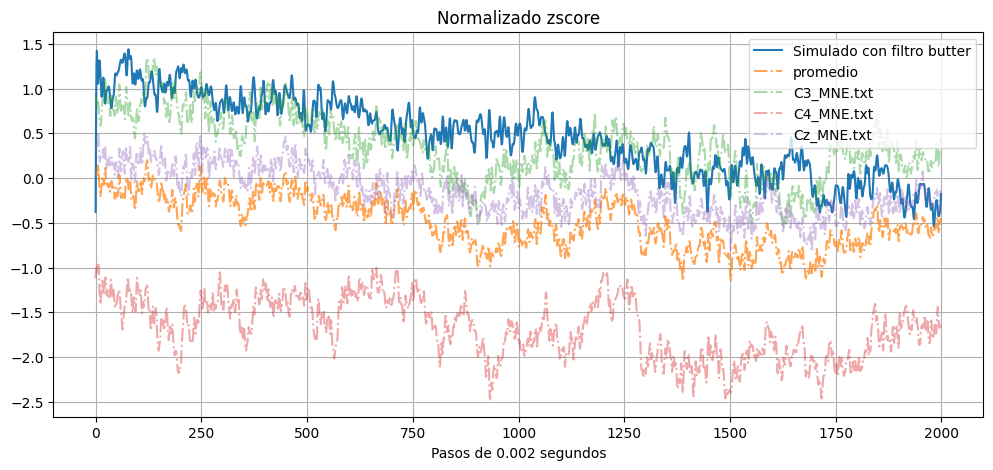

In [93]:
fig, ax = plt.subplots(figsize=[12, 5])
print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"],label="Simulado con filtro butter")
grupos = np.array(reales_total["datos"])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(len(reales_total["datos"])):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.4)


plt.xlabel("Pasos de 0.002 segundos")
#plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


22.563278859730083
['C3_MNE.txt', 'C4_MNE.txt', 'Cz_MNE.txt']
Delta [np.float64(7.821942072499379), np.float64(6.963580573336321)] ---- [np.float64(7.163355786515751), np.float64(3.984426692546426)]
Theta [np.float64(-2.3287566881451833), np.float64(1.6342563623483883)] ---- [np.float64(0.005547866973192909), np.float64(2.160636671354848)]
Alpha [np.float64(-6.495079085849712), np.float64(1.503398621562725)] ---- [np.float64(-6.326656011719613), np.float64(2.1662623012274866)]
Beta [np.float64(-8.910061910389715), np.float64(1.4330146357454216)] ---- [np.float64(-9.382252563939005), np.float64(2.1145973072544577)]


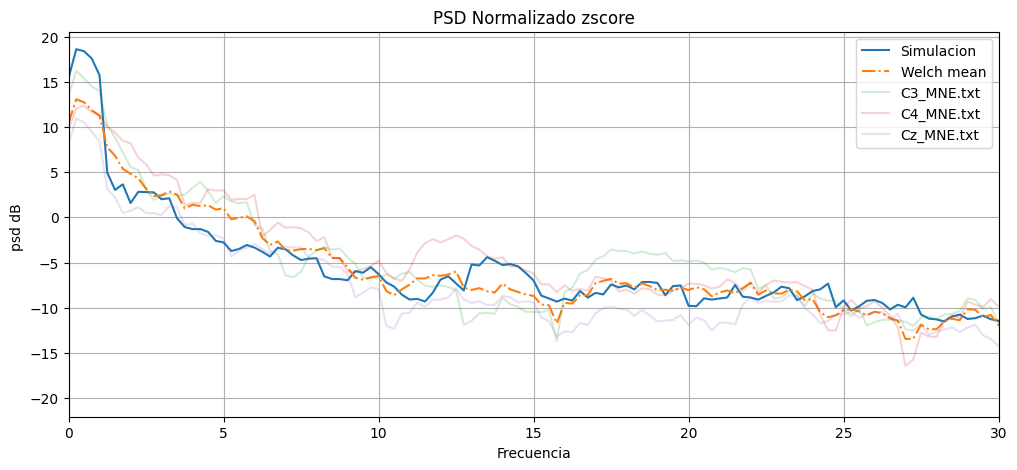

In [94]:
fig, ax = plt.subplots(figsize=[12, 5])

hi2_stat = euclidean_distance(generated_data["welch_data"][:121],reales_total["mean_welch"][:121])

print(abs(hi2_stat))
print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(len(reales_total["datos"])):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.2)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


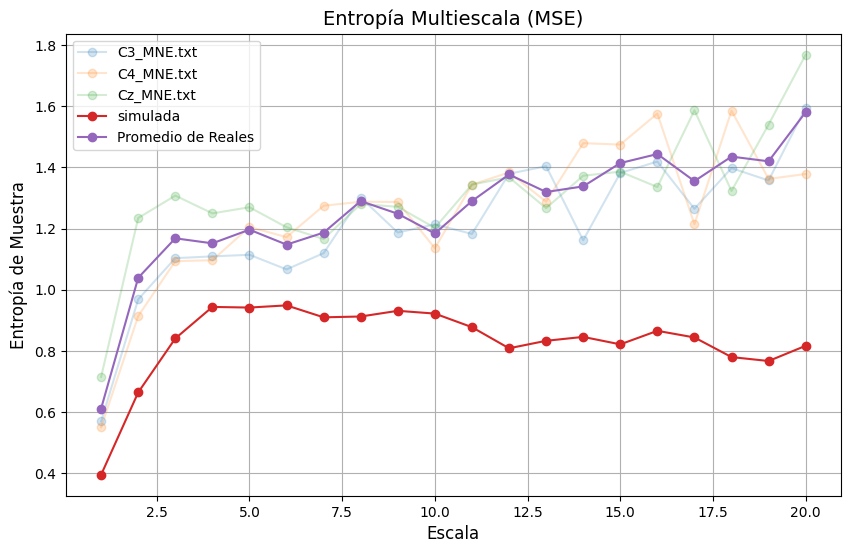

In [95]:
def coarse_grain(series, scale):
    length = len(series)
    coarse_grained = [
        np.mean(series[i * scale:(i + 1) * scale])
        for i in range(length // scale)
    ]
    return np.array(coarse_grained)

# Función para calcular MSE
def multiscale_entropy(series, max_scale, m=2, r=0.2):

    mse_values = []
    sd = np.std(series)  # Calcula la desviación estándar de la serie
    tolerance = r * sd  # Define la tolerancia
    
    for scale in range(1, max_scale + 1):
        coarse_grained_series = coarse_grain(series, scale)
        # Calcula SampEn para la serie granularizada
        entropy = sampen(coarse_grained_series, emb_dim=m, tolerance=tolerance)
        mse_values.append(entropy)
    
    return mse_values

# Datos de ejemplo

max_scale = 20
all_mse_results = []
plt.figure(figsize=(10, 6))
for i, señal in enumerate(reales_total["datos"]):
    mse_result = multiscale_entropy(señal, max_scale)
    all_mse_results.append(mse_result)
    plt.plot(range(1, max_scale + 1), mse_result, marker='o', label=reales_total["Nombres"][i],alpha=0.2)

mse_result_S= multiscale_entropy(generated_data["butter"], max_scale)
plt.plot(range(1, max_scale + 1), mse_result_S, marker='o', label=f"simulada")

all_mse_array = np.array(all_mse_results)
mse_mean_across_signals = all_mse_array.mean(axis=0)  # Promedio en cada escala
plt.plot(range(1, max_scale + 1), mse_mean_across_signals, marker='o', label="Promedio de Reales")

plt.title(f"Entropía Multiescala (MSE)", fontsize=14)
plt.xlabel("Escala", fontsize=12)
plt.ylabel("Entropía de Muestra", fontsize=12)
plt.grid()
plt.legend()
plt.show()


In [ ]:
Tipo_de_red="Random"


def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,40)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0,5.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)x
    params[6] = 12112
    params[7] = trial.suggest_int('Tipo_red',3,4)

    generated= Simulado_EGG(params,Normalizacion)
    if generated["delta"][1]-generated["delta"][1]==0:
        hi2_stat=euclidean_distance(generated["welch_data"][:121],reales_total["mean_welch"][:121])
        trial.report(hi2_stat, step=trial.number)### general
        return hi2_stat
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            #pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-12-01 19:41:39,459] Using an existing study with name 'Chi30_Random_zscore' instead of creating a new one.
[I 2024-12-01 19:42:12,696] Trial 372 finished with value: 46.86151479873091 and parameters: {'L': 36, 'P': 0.09641827954789783, 'Inh': 0.5334563127653601, 'Trest': 2.2870134849865753, 'Trelative': 7.768899859569685, 'C_h': 0.057890260876044375, 'Tipo_red': 4}. Best is trial 271 with value: 29.18897524467193.
[I 2024-12-01 19:42:43,191] Trial 373 finished with value: 48.13132837530003 and parameters: {'L': 35, 'P': 0.0689760096959558, 'Inh': 0.5119752931126109, 'Trest': 1.8070490844791784, 'Trelative': 9.052157371932005, 'C_h': 0.09731442299740442, 'Tipo_red': 4}. Best is trial 271 with value: 29.18897524467193.
[W 2024-12-01 19:45:52,655] Trial 374 failed with parameters: {'L': 37, 'P': 0.4987617231071209, 'Inh': 0.46726817453970504, 'Trest': 1.7389582543971291, 'Trelative': 8.318198713696207, 'C_h': 0.04429938241812735, 'Tipo_red': 4} because of the following error: Keyb

KeyboardInterrupt: 

In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


Chi30_SW_zscore

Trial 1:
Params: {'L': 24, 'P': 0.9940303763408532, 'Inh': 0.9511555357465337, 'Trest': 0.2717976931065515, 'Trelative': 0.9974224129209002, 'C_h': 0.13002347823844906, 'Tipo_red': 2}
Value: 20.898396308518073

Trial 2:
Params: {'L': 48, 'P': 0.1488126904754729, 'Inh': 0.9337825842743673, 'Trest': 0.6571473709523385, 'Trelative': 0.9156244996362424, 'C_h': 0.1895987472764896, 'Tipo_red': 2}
Value: 21.866982980186343

Trial 3:
Params: {'L': 24, 'P': 0.10366159640068666, 'Inh': 0.9051235524489825, 'Trest': 0.6193424852659013, 'Trelative': 0.9905926499096843, 'C_h': 0.10725260686388498, 'Tipo_red': 2}
Value: 22.69897938976322

Trial 4:
Params: {'L': 24, 'P': 0.14997207240505633, 'Inh': 0.9804033596252063, 'Trest': 0.5667216043011205, 'Trelative': 0.9101989962979946, 'C_h': 0.10916178419806502, 'Tipo_red': 2}
Value: 23.25139143961789

Trial 5:
Params: {'L': 38, 'P': 0.13790062317992935, 'Inh': 0.9436854802687896, 'Trest': 0.6436863954294088, 'Trelative': 0.8722642893660105

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 2451, 2452, 2453],
              'y': [inf, 1613.38949131814, inf, ..., 60.79034996479649,
                    873.7143909613517, 54.272691615828016]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 2451, 2452, 2453],
              'y': [inf, 1613.38949131814, 1613.38949131814, ...,
                    20.898396308518073, 20.898396308518073, 20.898396308518073]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [37]:
vis.plot_param_importances(study)

[W 2024-11-28 16:48:56,881] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:48:56,882] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:48:56,883] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:48:56,883] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:48:56,884] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:48:56,885] Trial 9 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:48:56,885] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:48:56,886] Trial 14 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:48:56,886] Trial 17 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:48:56,887] Trial 

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [C_h (FloatDistribution): 1.0<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [1.00],
              'textposition': 'outside',
              'type': 'bar',
              'x': [1.0],
              'y': [C_h]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [38]:
vis.plot_parallel_coordinate(study)

[W 2024-11-28 16:49:15,395] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:49:15,396] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:49:15,396] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:49:15,396] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:49:15,397] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:49:15,397] Trial 9 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:49:15,398] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:49:15,398] Trial 14 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:49:15,399] Trial 17 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-28 16:49:15,399] Trial 

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'dimensions': [{'label': 'Objective Value',
                              'range': [20.898396308518073, 3516.8974633027683],
                              'values': [1613.38949131814, 60.175203988251916,
                                         1613.38949131814, ..., 60.79034996479649,
                                         873.7143909613517, 54.272691615828016]},
                             {'label': 'C_h',
                              'range': [1.8547127094363514e-05,
                                        0.9982207837468707],
                              'values': [0.8455838625341021, 0.9185354331805016,
                                         0.2496121695450514, ...,
                                         0.09706758221864924, 0.02764204179154267,
                                         0.17443134619142683]},
                             {'label': 'Inh',
                              'range': [0.0007660131525932812, 0.9999905065338585],
                              'values': [0.8611199001311037, 0.2370321419109832,
                                         0.6407556930740387, ...,
                                         0.6996865216022243, 0.6996683800965043,
                                         0.6996559934078406]},
                             {'label': 'L',
                              'range': [10, 100],
                              'values': [27, 17, 16, ..., 40, 24, 36]},
                             {'label': 'P',
                              'range': [0.0, 0.9999767770656718],
                              'values': [0.3282178218171282, 0.33279483857838743,
                                         0.7893721977271843, ...,
                                         0.15097105625624463, 0.9101585260984543,
                                         0.10426971511795745]},
                             {'label': 'Tipo_red',
                              'range': [0, 2],
                              'values': [1, 1, 1, ..., 2, 2, 2]},
                             {'label': 'Trelative',
                              'range': [0.02968001946815335, 19.254046606467178],
                              'values': [7.164764242340821, 6.655647794469701,
                                         1.4315275059553174, ...,
                                         1.1922138882213473, 0.8425128019287931,
                                         1.0340770111211706]},
                             {'label': 'Trest',
                              'range': [0.00010479571910221308, 9.736841277234268],
                              'values': [1.84922291122184, 0.7163974480862517,
                                         1.104601452943796, ...,
                                         0.7937606950801404, 0.5058336994603084,
                                         0.6732071612442005]}],
              'labelangle': 30,
              'labelside': 'bottom',
              'line': {'color': [1613.38949131814, 60.175203988251916,
                                 1613.38949131814, ..., 60.79034996479649,
                                 873.7143909613517, 54.272691615828016],
                       'colorbar': {'title': {'text': 'Objective Value'}},
                       'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                      'rgb(222,235,247)'], [0.25,
                                      'rgb(198,219,239)'], [0.375,
                                      'rgb(158,202,225)'], [0.5,
                                      'rgb(107,174,214)'], [0.625,
                                      'rgb(66,146,198)'], [0.75,
                                      'rgb(33,113,181)'], [0.875, 'rgb(8,81,156)'],
                                      [1.0, 'rgb(8,48,107)']],
                       'reversescale': True,
                       'showscale': True},
              'type': 'parcoords'}],
    'layout': {'template': '...', 'title': {'text': 'Parallel Coordinate Plot'}}
})

In [ ]:
optuna.visualization.plot_slice(study)